## Benchmarking stochastic optimization algorithms

Stochastic optimization deals with problems whose fitness function is stochastic rather than fixed. That means that the fitness of an individual depends on its chromosome $x$ and some (pseudo)random number $w$ derived from a probability distribution $W$. Since $w$ is changes according to the sample-size with each evaluation, there is no fixed optimum. However, the expected value of the optimal solution does still exist. Thus, formally we want to find $x$ such that $E\left(f(x, w)\right)$ is minimal.

In [1]:
import pygmo as pg
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from time import time
%matplotlib inline

As an example of a stochastic optimization problem, let us define a simple one:
$$
f(x, w) = \left(\sum_{i}^{d} x_i^2\right)^{\frac15} + w
$$
where $w = \frac{1}{s} \sum\limits_{j}^{s} w_j$, where each $w_j \in \mathcal{N(0,1)}$ is a normally distributed noise term drawn independently.

For a 2-dimensional problem ($d = 2$) without noise, this function has its optimum at $(0,0)$ and looks like: 

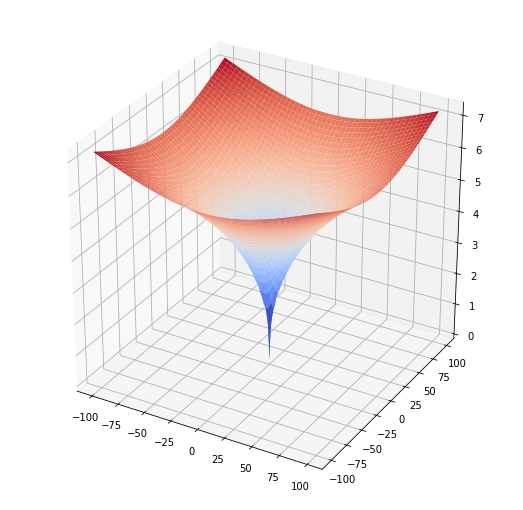

In [2]:
fig = plt.figure()
fig.set_size_inches(9,9)
ax = fig.gca(projection='3d')

X, Y = np.arange(-100, 100, 1), np.arange(-100, 100, 1)
X, Y = np.meshgrid(X, Y)
Z = (X**2 + Y**2)**(1.0/5.0)

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=1, antialiased=True)

Let us define a UDP to represent this particular problem but with stochastic noise/perturbances:

In [3]:
class stprob:
    def __init__(self, dim = 2, seed = np.random.randint(123456789), sample_size = 10):
        self.dim = dim
        self.seed = seed
        self.sample_size = sample_size

    def fitness(self, x):
        # the state of the random number generator needs to correspond to the current seed
        np.random.seed(self.seed)
        noise = sum(np.random.normal(0,1,self.sample_size)) / self.sample_size
        objfun = sum([xi**2 for xi in x])**(1.0/5.0)
        return [objfun + noise]
    
    def get_bounds(self):
        return ([-100] * self.dim, [100] * self.dim)
    
    def get_name(self):
        return "Stochastic test problem"

    def set_seed(self, seed):
        # stochastic optimizers call this method to ensure the calls to fitness are
        self.seed = seed

    def get_extra_info(self):
        s = "\tDimension: {}\n".format(self.dim)
        s += "\tSeed: {}\n".format(self.seed)
        s += "\tSample size: {}\n".format(self.sample_size)
        return s

Now the landscape of will look much more rugged and its shape will depend on the seed:

In [4]:
dim, sample_size = 2, 100
seed = 889
udp = stprob(dim, seed, sample_size)

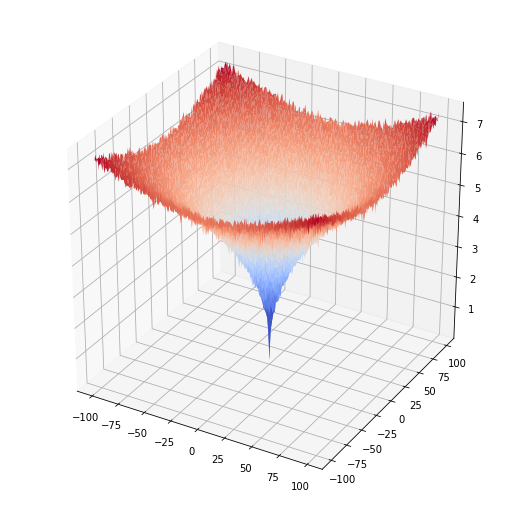

In [5]:
fig = plt.figure()
fig.set_size_inches(9,9)
ax = fig.gca(projection='3d')

X, Y = np.arange(-100, 100, 1), np.arange(-100, 100, 1)
X, Y = np.meshgrid(X, Y)
Z = np.zeros(X.shape)
for (x, y), v in np.ndenumerate(X):
    Z[x,y] = udp.fitness([X[x,y], Y[x,y]])[0]
    # evaluate each point with a different random perturbation
    udp.set_seed(np.random.randint(12345678))
    
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=1, antialiased=True)

This shows the fitness landscape an optimizer would explore during **one** generation only. Each following generation will have to deal with another distorted version as the seed will have changed. This is a real challenge for the algorithms in higher dimensions!

We will first generate a $d = 10$ variant for benchmarking:

In [26]:
dim, sample_size = 10, 100
seed = 889
udp = stprob(dim, seed, sample_size)
prob = pg.problem(udp)

There are a couple of algorithms already in pagmo that are able to optimize stochastic problems. We will instantiate 4 of them, give them enough time and compare their performance:

In [27]:
gens, popsize = 5000, 50

In [28]:
fit, cpu_times, best_xs = [], [], []
for uda in [pg.pso_generational(gens),pg.sga(gens),pg.cmaes(gens, xtol = 0.0, ftol= 0.0),pg.sea(gens)]:
    alg = pg.algorithm(uda)
    alg.set_verbosity(10)
    pop = pg.population(prob, popsize)
    t = time()
    pop = alg.evolve(pop)
    cpu_times.append(time() - t)
    log = alg.extract(type(uda)).get_log()
    # the fitness is included in the 2nd column of each log
    fit.append([line[2] for line in log])
    best_xs.append(pop.get_x()[pop.best_idx()])

In [13]:
labels = ['PSO', 'SGA', 'CMAES', '(N+1)-ES']
generations = np.arange(0,gens, 10)

We plot the change in fitness over time:

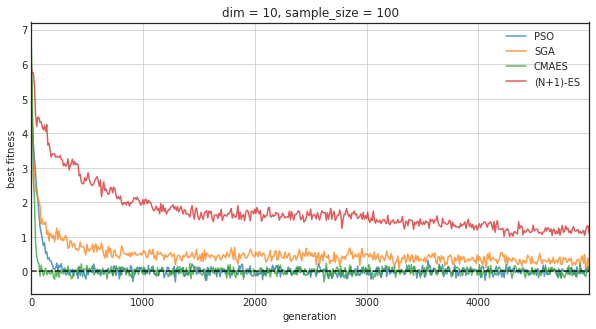

In [14]:
with plt.style.context(('seaborn-white')):
    fig, ax = plt.subplots()
    fig.set_size_inches(10,5)
    for f in fit:
        ax.plot(generations, f, alpha = 0.75)
    ax.plot([0, max(generations)], [0,0], 'k--', alpha = 0.8)
    ax.set_xlabel('generation')
    ax.set_ylabel('best fitness')
    ax.set_xlim([0, max(generations)])
    ax.set_title('dim = {}, sample_size = {}'.format(dim, sample_size))
    ax.grid()
    ax.legend(labels)

The best spot to live in this stochastic landscape is still at zero. We check how close each algorithm came to this point:

In [15]:
opt = np.zeros(dim)
print('Distance to optimum:')
for x, label in zip(best_xs, labels):
    dist = np.linalg.norm(x)
    print('\t{0}: {1:0.2e}'.format(label, dist))   

Distance to optimum:
	PSO: 4.11e-42
	SGA: 4.19e-02
	CMAES: 1.76e-44
	(N+1)-ES: 1.58e+00


In [16]:
print('CPU-time')
for t, label in zip(cpu_times, labels):
    print('\t{0}: {1:0.2e}'.format(label, t)) 

CPU-time
	PSO: 2.37e+01
	SGA: 2.37e+01
	CMAES: 1.25e+01
	(N+1)-ES: 1.20e+01


The differences between the algorithms become more apparent if $d$ increases from $10$ to $100$:

In [17]:
dim, sample_size = 100, 100
seed = 889
udp = stprob(dim, seed, sample_size)

In [18]:
prob = pg.problem(udp)

In [19]:
gens, popsize = 5000, 50

In [20]:
fit, cpu_times, best_xs = [], [], []
for uda in [pg.pso_generational(gens),pg.sga(gens),pg.cmaes(gens, xtol = 0.0, ftol= 0.0),pg.sea(gens)]:
    alg = pg.algorithm(uda)
    alg.set_verbosity(10)
    pop = pg.population(prob, popsize)
    t = time()
    pop = alg.evolve(pop)
    cpu_times.append(time() - t)
    log = alg.extract(type(uda)).get_log()
    # the fitness is included in the 2nd column of each log
    fit.append([line[2] for line in log])
    best_xs.append(pop.get_x()[pop.best_idx()])

In [21]:
labels = ['PSO', 'SGA', 'CMAES', '(N+1)-ES']
generations = np.arange(0,gens, 10)

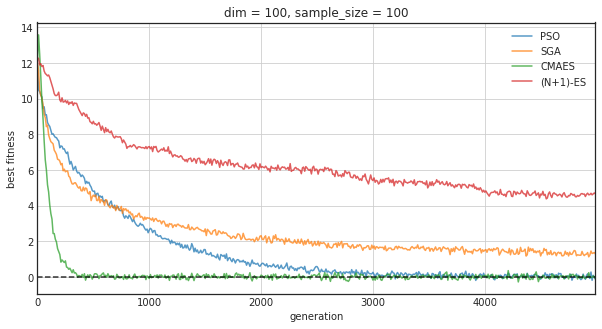

In [22]:
with plt.style.context(('seaborn-white')):
    fig, ax = plt.subplots()
    fig.set_size_inches(10,5)
    for f in fit:
        ax.plot(generations, f, alpha = 0.75)
    ax.plot([0, max(generations)], [0,0], 'k--', alpha = 0.8)
    ax.set_xlabel('generation')
    ax.set_ylabel('best fitness')
    ax.set_xlim([0, max(generations)])
    ax.set_title('dim = {}, sample_size = {}'.format(dim, sample_size))
    ax.grid()
    ax.legend(labels)

In [23]:
opt = np.zeros(dim)
print('Distance to optimum:')
for x, label in zip(best_xs, labels):
    dist = np.linalg.norm(x)
    print('\t{0}: {1:0.2e}'.format(label, dist))

Distance to optimum:
	PSO: 2.61e-05
	SGA: 1.88e+00
	CMAES: 1.62e-42
	(N+1)-ES: 4.52e+01


In [24]:
print('CPU-time')
for t, label in zip(cpu_times, labels):
    print('\t{0}: {1:0.2e}'.format(label, t))

CPU-time
	PSO: 4.37e+01
	SGA: 4.28e+01
	CMAES: 1.25e+02
	(N+1)-ES: 2.14e+01
